In [3]:
import math
import numpy as np
from cv2 import Rodrigues
from math import sin, cos, atan2, sqrt
import pandas as pd
from pathlib import Path
import pyproj
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [4]:
smp = pd.read_csv("/kaggle/input/gia-smp-va-smpcap-2021-csv/Gia SMP va SMPcap 2021(Gia thi truong SMP).csv" , encoding='latin-1', sep=';' )

In [5]:
smp.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [6]:
feats = ['Ngày','15', '16','17']
smp[feats].head()

,Ngày,15,16,17
0,01/01/2021,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4
3,01/04/2021,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5


In [7]:
# Tạo một hàm để kiểm tra nếu 3 giá trị trong dòng là khác nhau
def is_unique(row):
    return len(set(row)) == len(row)

# Áp dụng hàm vào từng dòng của DataFrame
unique_rows = smp[feats].apply(is_unique, axis=1)

# Đếm số lượng dòng có giá trị khác nhau
num_unique_rows = unique_rows.sum()

print(f"Số lượng dòng có giá trị khác nhau trong 3 cột là: {num_unique_rows}")

Số lượng dòng có giá trị khác nhau trong 3 cột là: 0


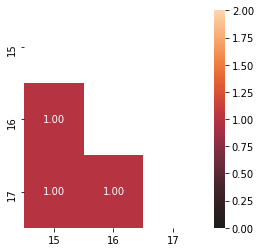

In [8]:
import seaborn as sns
mask = np.triu(np.ones_like(smp[feats].corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(4,4))
sns.heatmap(smp[feats].corr(), mask=mask, vmax=2, vmin=0, center=0,annot=True,fmt='.2f');

In [9]:
import plotly.graph_objects as go

fig = go.Figure()
# Add the first line for column '15'
fig.add_trace(go.Scatter(x=smp['Ngày'], y=smp['15'],
                         mode='lines',
                         name='Column 15',
                         line=dict(color='black')))

# Add the second line for column '16'
fig.add_trace(go.Scatter(x=smp['Ngày'], y=smp['16'],
                         mode='lines',
                         name='Column 16',
                         line=dict(color='red')))
# Add the second line for column '17'
fig.add_trace(go.Scatter(x=smp['Ngày'], y=smp['17'],
                         mode='lines',
                         name='Column 17',
                         line=dict(color='green')))

# Update layout
fig.update_layout(
    xaxis_title="Ngày",
    yaxis_title="Cột 15,16,17",
    title={'text': "Data", 'y': 0.95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'}
)

# Show the plot
fig.show()

In [10]:
smp = smp[feats]

In [11]:
!pip install filterpy

     |████████████████████████████████| 177 kB 5.8 MB/s eta 0:00:01
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110451 sha256=694ad0e407238adc2a157f3a0df92e52156565f9eff53d209e881c91be7987b1
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy


In [12]:
import numpy as np
import pandas as pd
from filterpy.kalman import KalmanFilter

def apply_kalman_filter(data):
    kf = KalmanFilter(dim_x=2, dim_z=1)

    kf.x = np.array([[0.], [0.]])       
    kf.F = np.array([[1., 1.], [0., 1.]])  
    kf.H = np.array([[1., 0.]])          
    kf.P *= 1000.                        
    kf.R = 5                             
    kf.Q = np.array([[0.0001, 0.001], [0.001, 0.1]]) 

    predictions = []
    for z in data:
        kf.predict()
        kf.update([z])
        predictions.append(kf.x[0][0])

    return predictions

# Áp dụng Kalman Filter cho từng cột
smp['15_filtered'] = apply_kalman_filter(smp['15'])
smp['16_filtered'] = apply_kalman_filter(smp['16'])
smp['17_filtered'] = apply_kalman_filter(smp['17'])

# Hiển thị kết quả
print(smp[['15', '15_filtered', '16', '16_filtered', '17', '17_filtered']])


         15  15_filtered      16  16_filtered      17  17_filtered
0     964.4   961.995013   964.4   961.995013   964.4   961.995013
1    1019.7  1023.799125  1019.7  1023.799125  1019.7  1023.799125
2     988.4  1005.918162   988.4  1005.918162   988.4  1005.918162
3    1010.8  1014.292536  1010.8  1014.292536  1010.8  1014.292536
4    1061.5  1048.029079  1061.5  1048.029079  1061.5  1048.029079
..      ...          ...     ...          ...     ...          ...
360  1002.1   989.853859  1002.1   989.853856  1002.1   989.853856
361  1002.0   990.314853  1002.0   990.314854  1002.0   990.314854
362  1061.5  1016.493574  1061.5  1016.493578  1061.5  1016.493578
363  1022.6  1020.589442  1022.6  1020.589447  1022.6  1020.589447
364  1022.6  1023.206502  1022.6  1023.206507  1022.6  1023.206507

[365 rows x 6 columns]


In [13]:
smp=smp.drop(['15','16','17'], axis=1)
smp.head()

,Ngày,15_filtered,16_filtered,17_filtered
0,01/01/2021,961.995013,961.995013,961.995013
1,01/02/2021,1023.799125,1023.799125,1023.799125
2,01/03/2021,1005.918162,1005.918162,1005.918162
3,01/04/2021,1014.292536,1014.292536,1014.292536
4,01/05/2021,1048.029079,1048.029079,1048.029079


In [18]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
df = smp
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')
df.sort_values(by='Ngày', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
test_size = 30

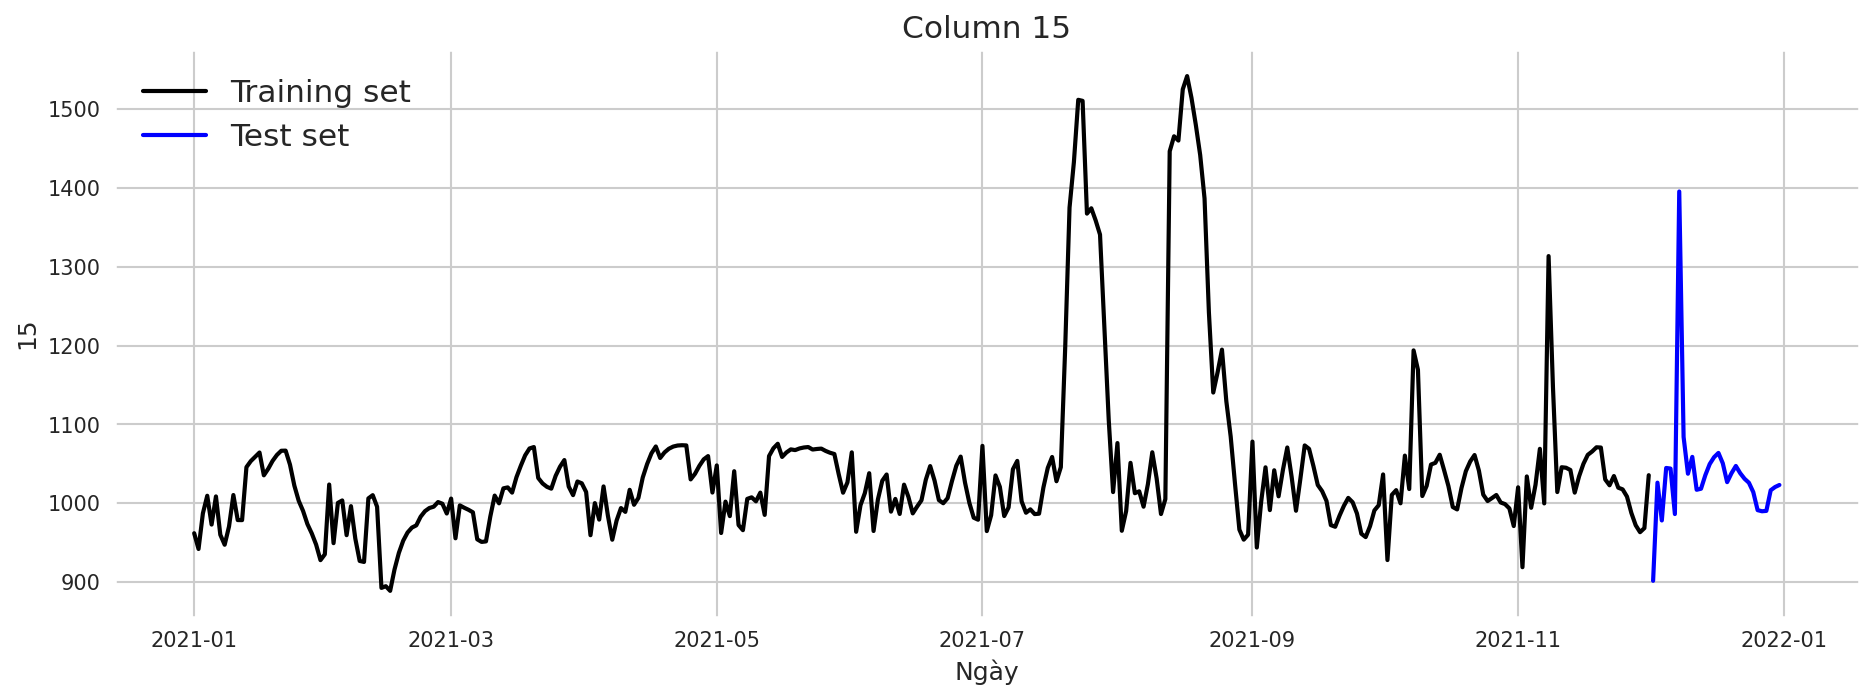

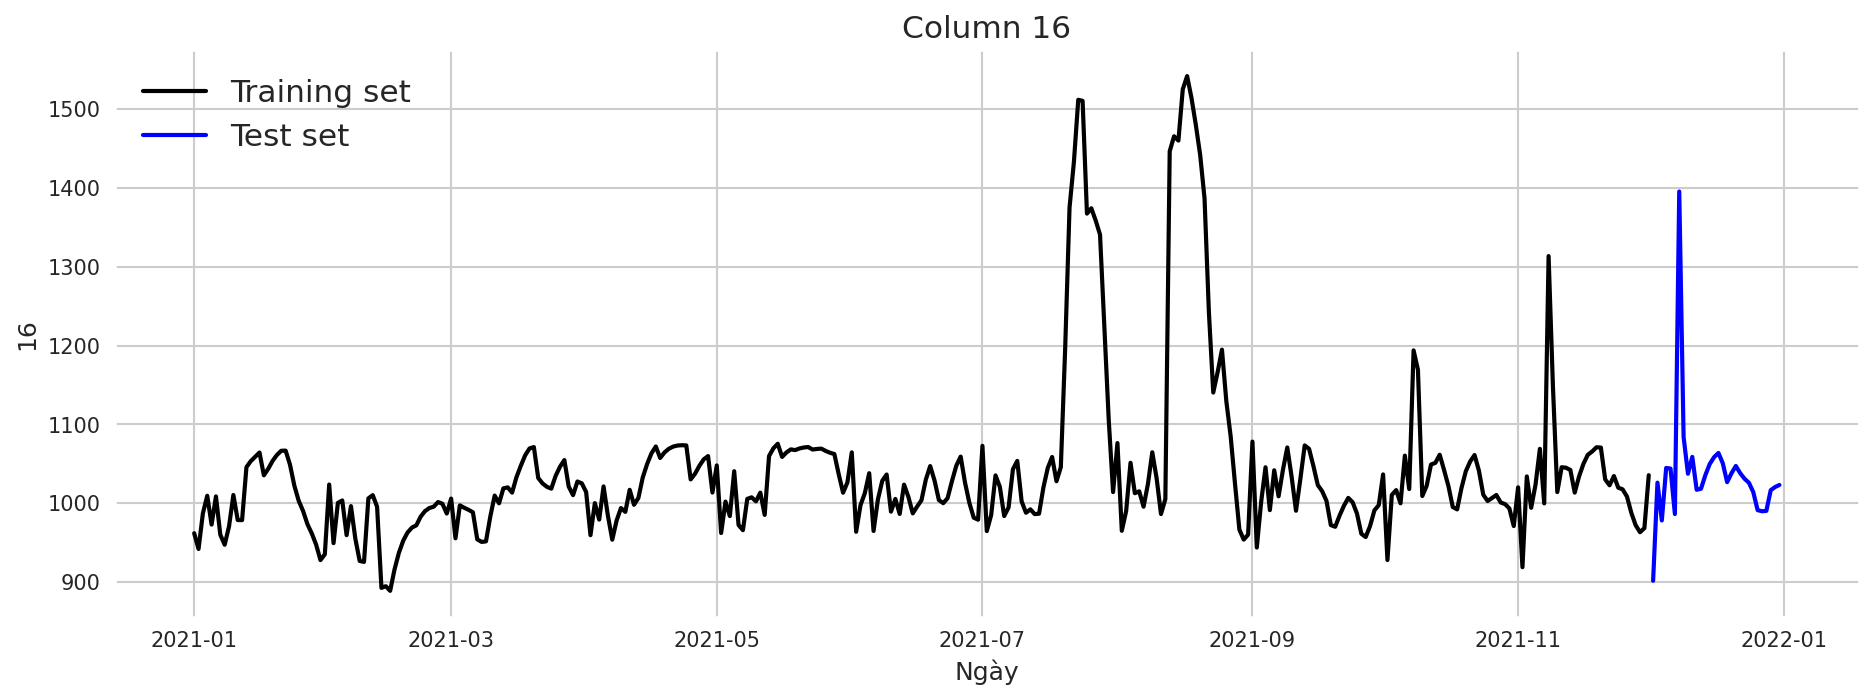

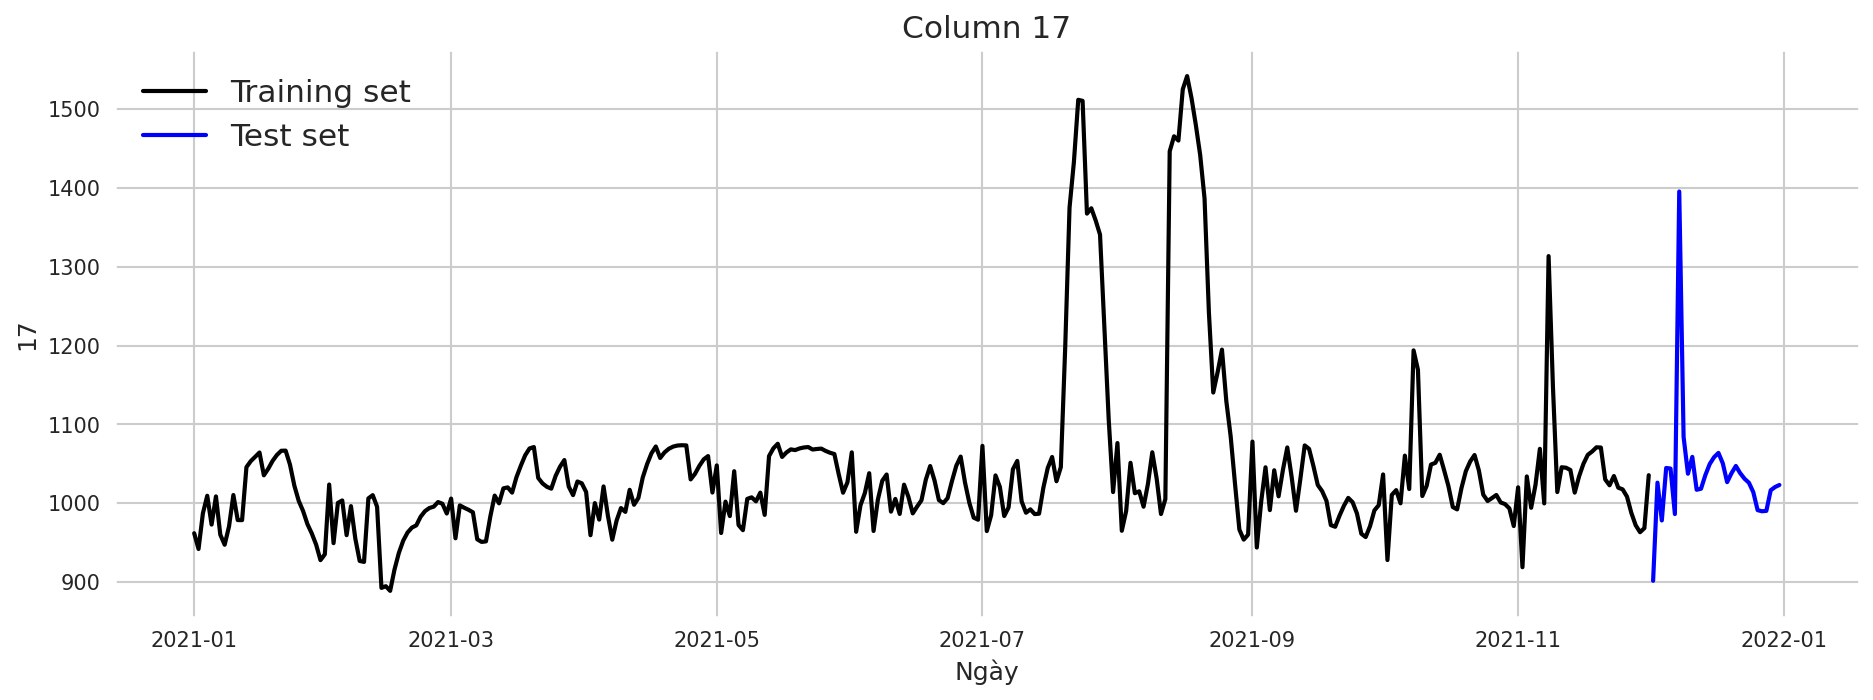

In [20]:
# Plot for column '15'
plt.figure(figsize=(15, 5), dpi=150)
plt.rc('axes', edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['15_filtered'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['15_filtered'][-test_size:], color='blue', lw=2)
plt.title('Column 15', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('15', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.show()

# Plot for column '16'
plt.figure(figsize=(15, 5), dpi=150)
plt.rc('axes', edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['16_filtered'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['16_filtered'][-test_size:], color='blue', lw=2)
plt.title('Column 16', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('16', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.show()

# Plot for column '17'
plt.figure(figsize=(15, 5), dpi=150)
plt.rc('axes', edgecolor='white')
plt.plot(df['Ngày'][:-test_size], df['17_filtered'][:-test_size], color='black', lw=2)
plt.plot(df['Ngày'][-test_size:], df['17_filtered'][-test_size:], color='blue', lw=2)
plt.title('Column 17', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('17', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.show()

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['15_filtered','16_filtered','17_filtered']].values.reshape(-1,1))

MinMaxScaler()

In [23]:
!pip install pandas statsmodels scikit-learn prophet

     |████████████████████████████████| 14.4 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 598 kB 39.3 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 1.0 MB/s  eta 0:00:01
     |████████████████████████████████| 15.7 MB 36.8 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: holidays
    Found existing installation: holidays 0.11.1
    Uninstalling holidays-0.11.1:
      Successfully uninstalled holidays-0.11.1
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 

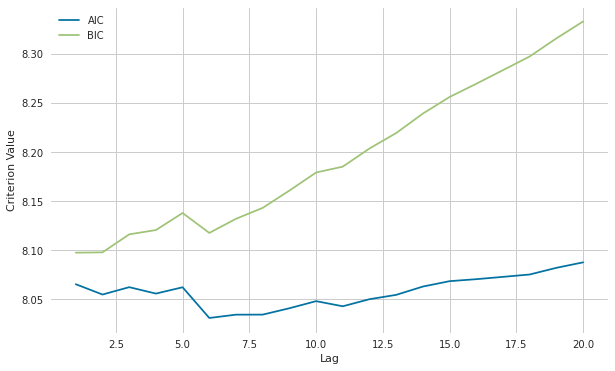

Optimal lag (AIC): 6
Optimal lag (BIC): 1


In [27]:

# Hàm để tính toán AIC và BIC cho nhiều giá trị lags
def calculate_aic_bic(data, max_lag):
    aic_values = []
    bic_values = []
    for lag in range(1, max_lag + 1):
        model = AutoReg(data, lags=lag)
        model_fit = model.fit()
        aic_values.append(model_fit.aic)
        bic_values.append(model_fit.bic)
    return aic_values, bic_values

# Tính toán AIC và BIC cho các giá trị lags từ 1 đến 20
max_lag = 20
aic_values, bic_values = calculate_aic_bic(data, max_lag)

# Vẽ biểu đồ AIC và BIC
lags = np.arange(1, max_lag + 1)
plt.figure(figsize=(10, 6))
plt.plot(lags, aic_values, label='AIC')
plt.plot(lags, bic_values, label='BIC')
plt.xlabel('Lag')
plt.ylabel('Criterion Value')
plt.legend()
plt.show()

# Chọn số lượng lags tối ưu dựa trên AIC hoặc BIC thấp nhất
optimal_lag_aic = lags[np.argmin(aic_values)]
optimal_lag_bic = lags[np.argmin(bic_values)]
print(f'Optimal lag (AIC): {optimal_lag_aic}')
print(f'Optimal lag (BIC): {optimal_lag_bic}')

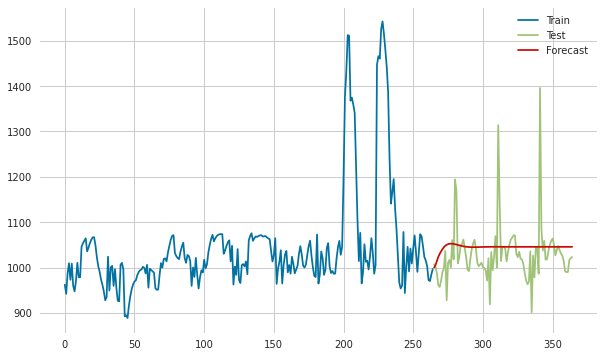

Predictions:
265    1000.027761
266    1005.329817
267    1014.542692
268    1023.488693
269    1030.215587
          ...     
360    1045.589086
361    1045.589094
362    1045.589104
363    1045.589115
364    1045.589125
Length: 100, dtype: float64


In [28]:
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

# Chọn cột để dự báo, giả sử là 'col1'
data = df['15_filtered']

optimal_lag = optimal_lag_aic 
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train = data[:-100]
test = data[-100:]

# Khởi tạo và huấn luyện mô hình AR
model = AutoReg(train, lags=optimal_lag)  # lags=5 là số lượng các lag observations
model_fit = model.fit()

# Dự báo
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Vẽ biểu đồ kết quả
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Forecast')
plt.legend()
plt.show()

print(f"Predictions:\n{predictions}")


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính toán các độ đo đánh giá
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 39.821545072089
Mean Squared Error (MSE): 4058.2513617443933
Root Mean Squared Error (RMSE): 63.704406140740325


<Figure size 720x432 with 0 Axes>

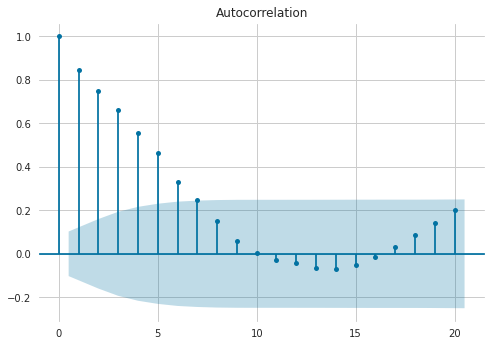

<Figure size 720x432 with 0 Axes>

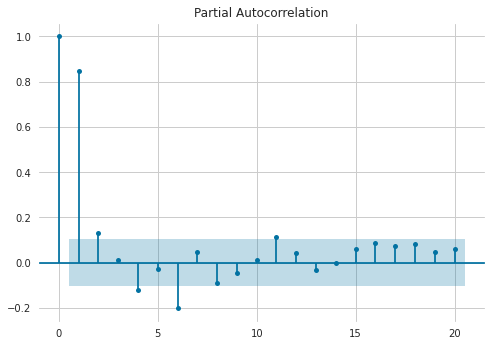

In [32]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Chọn cột để phân tích, giả sử là 'col1'
data = df['15_filtered']

# Vẽ đồ thị tự tương quan (ACF)
plt.figure(figsize=(10, 6))
plot_acf(data, lags=20)
plt.show()

# Vẽ đồ thị tự tương quan riêng phần (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(data, lags=20)
plt.show()

In [35]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print('Chuỗi thời gian không dừng, cần differencing.')
    # Differencing lần 1
    data_diff = data.diff().dropna()
    result = adfuller(data_diff)
    print(f'ADF Statistic after 1st differencing: {result[0]}')
    print(f'p-value: {result[1]}')
else:
    print('Chuỗi thời gian đã dừng.')

ADF Statistic: -5.697610938584553
p-value: 7.808303119972947e-07
Chuỗi thời gian đã dừng.


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Mean Absolute Error (MAE): 41.94691557182238
Mean Squared Error (MSE): 4279.8402821191185
Root Mean Squared Error (RMSE): 65.42048824427343


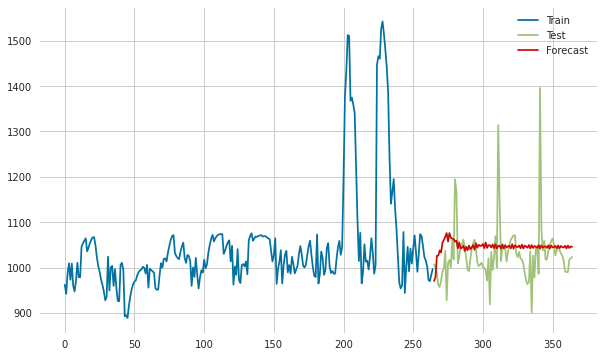

In [36]:
model = ARIMA(train, order=(14, 0, 10))  
model_fit = model.fit()
predictions = model_fit.forecast(steps=len(test))

mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Forecast')
plt.legend()
plt.show()